# **Problem 1** 
AlexNet is originally proposed for 227*227 image sizes. It may be too complex for the CIFAR-10 dataset, in particular, due to the low resolution of the initial images; try simplifying the model to make the training faster while ensuring that the accuracy stays relatively high. Report the training loss, validation loss, and validation accuracy. Also, report the number of parameters in your modified version of AlexNet and compare it against the number of parameters in the original AlexNet architectures.

In [3]:
# Main Libraries
import torch.optim as optim
import torch.nn as nn
import torch
import pandas as pd
import numpy as np

# Utility Libraries (QoL functions)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# Visualization and Evaluation Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

normalize = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])

training_dataset = datasets.CIFAR10(root='./data', train=True, transform=normalize)
validation_dataset = datasets.CIFAR10(root='./data', train=False, transform=normalize)

training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


In [2]:
class ModNet(nn.Module):
    def __init__(self):
        super(ModNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=1)
        
        self.conv3 = nn.Conv2d(128, 394, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(394, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)
        
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256*4*4, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.pool3(x)
        
        # Adaptive average pooling
        x = self.avgpool(x)
        
        # Fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x
        
# Initialize the network
model = ModNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

training_losses = []
training_accuracies = []

validation_losses = []
validation_accuracies = []

for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(training_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update(1)
    
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        training_loss = running_loss / len(training_loader)
        training_losses.append(training_loss)
        training_accuracy = 100 * correct / total
        training_accuracies.append(training_accuracy)
    
        model.eval()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        predicted_labels = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                
        validation_loss = running_loss / len(validation_loader.dataset)
        validation_losses.append(validation_loss)
        validation_accuracy = 100 * correct / total
        validation_accuracies.append(validation_accuracy)

        pbar.set_postfix({'Training Loss ': training_loss, 'Validation Loss ': validation_loss})

torch.save(model, 'ModNet')

Epoch 10/10: 100%|██████████| 1563/1563 [00:34<00:00, 45.74 batch/s, Training Loss =1.18, Validation Loss =0.0403]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 7, 7]          23,296
              ReLU-2             [-1, 64, 7, 7]               0
         MaxPool2d-3             [-1, 64, 5, 5]               0
            Conv2d-4            [-1, 128, 5, 5]         204,928
              ReLU-5            [-1, 128, 5, 5]               0
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Conv2d-7            [-1, 394, 3, 3]         454,282
              ReLU-8            [-1, 394, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         908,032
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

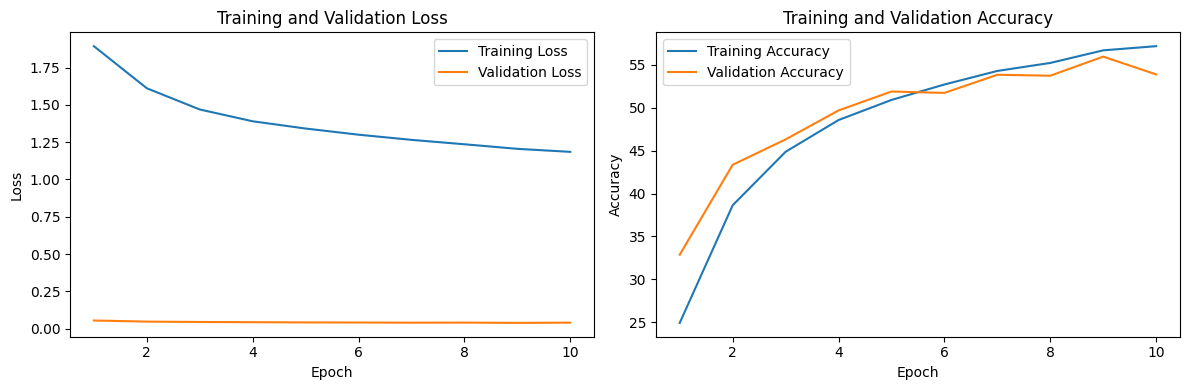

              precision    recall  f1-score   support

           0       0.62      0.63      0.62      1000
           1       0.62      0.70      0.65      1000
           2       0.35      0.53      0.42      1000
           3       0.33      0.45      0.38      1000
           4       0.64      0.31      0.41      1000
           5       0.43      0.44      0.43      1000
           6       0.62      0.65      0.64      1000
           7       0.74      0.53      0.62      1000
           8       0.65      0.71      0.68      1000
           9       0.69      0.44      0.54      1000

    accuracy                           0.54     10000
   macro avg       0.57      0.54      0.54     10000
weighted avg       0.57      0.54      0.54     10000



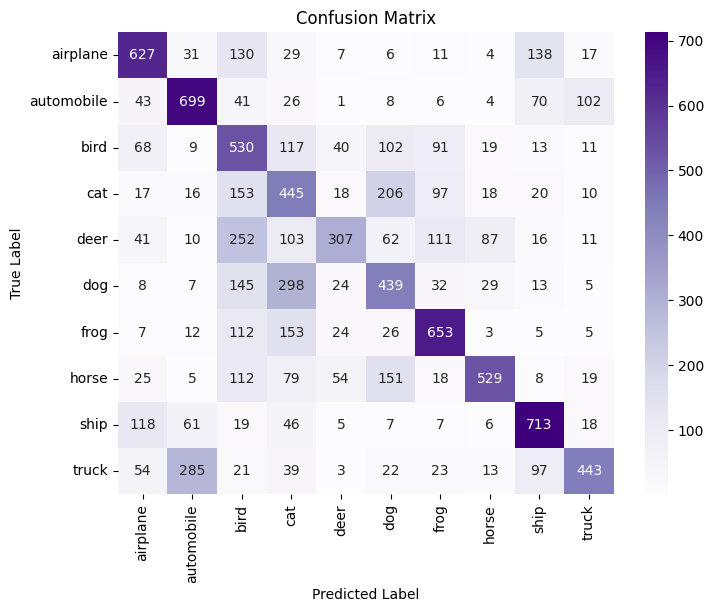

In [3]:
summary(model, (3, 32, 32))  # Input images are of shape (3, 32, 32)
print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Training Accuracy : {training_accuracies[-1]} %')
print(f'Final Validation Accuracy : {validation_accuracies[-1]} %')
epochs_range = range(1, epochs + 1)

# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)
print(report)

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Problem 1 with Dropout** 
Explore the option of applying Dropout techniques for training your customized AlexNet. Compare the training and validation results against the baseline model without any dropout.

In [5]:
class DropModNet(nn.Module):
    def __init__(self):
        super(DropModNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=1)
        
        self.conv3 = nn.Conv2d(128, 394, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(394, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)
        
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256*4*4, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.pool3(x)
        
        # Adaptive average pooling
        x = self.avgpool(x)

        # Fully connected layers
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x
        
# Initialize the network
model = DropModNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

training_losses = []
training_accuracies = []

validation_losses = []
validation_accuracies = []

for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(training_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update(1)
    
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        training_loss = running_loss / len(training_loader)
        training_losses.append(training_loss)
        training_accuracy = 100 * correct / total
        training_accuracies.append(training_accuracy)
    
        model.eval()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        predicted_labels = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                
        validation_loss = running_loss / len(validation_loader.dataset)
        validation_losses.append(validation_loss)
        validation_accuracy = 100 * correct / total
        validation_accuracies.append(validation_accuracy)

        pbar.set_postfix({'Training Loss ': training_loss, 'Validation Loss ': validation_loss})

torch.save(model, 'DropModNet')

Epoch 10/10: 100%|██████████| 1563/1563 [00:24<00:00, 64.03 batch/s, Training Loss =1.38, Validation Loss =0.0437]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 7, 7]          23,296
              ReLU-2             [-1, 64, 7, 7]               0
         MaxPool2d-3             [-1, 64, 5, 5]               0
            Conv2d-4            [-1, 128, 5, 5]         204,928
              ReLU-5            [-1, 128, 5, 5]               0
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Conv2d-7            [-1, 394, 3, 3]         454,282
              ReLU-8            [-1, 394, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         908,032
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

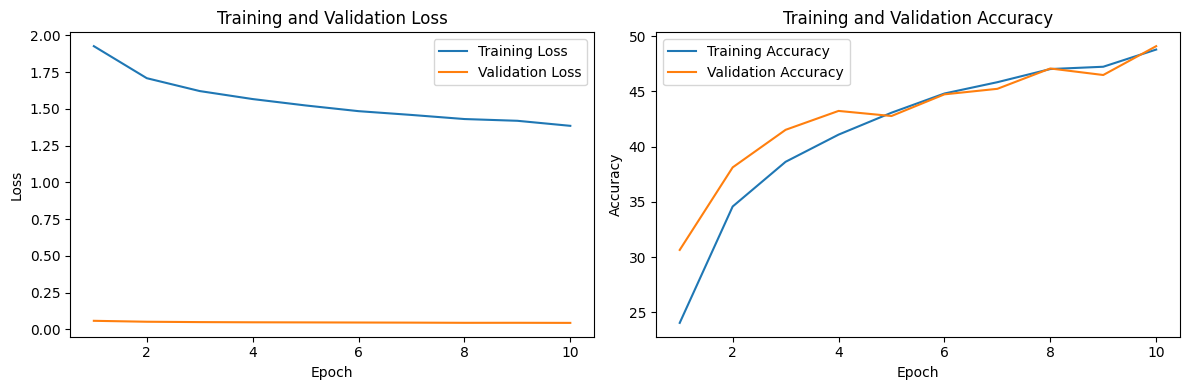

              precision    recall  f1-score   support

           0       0.59      0.57      0.58      1000
           1       0.58      0.47      0.52      1000
           2       0.42      0.19      0.26      1000
           3       0.32      0.20      0.25      1000
           4       0.42      0.47      0.44      1000
           5       0.40      0.43      0.41      1000
           6       0.45      0.76      0.57      1000
           7       0.57      0.60      0.58      1000
           8       0.62      0.76      0.68      1000
           9       0.48      0.44      0.46      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000



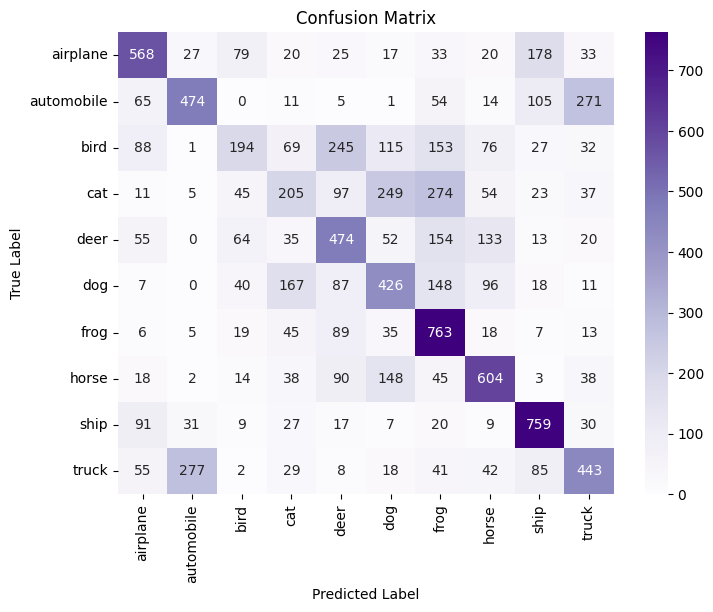

In [6]:
summary(model, (3, 32, 32))  # Input images are of shape (3, 32, 32)
print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Training Accuracy : {training_accuracies[-1]} %')
print(f'Final Validation Accuracy : {validation_accuracies[-1]} %')
epochs_range = range(1, epochs + 1)

# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)
print(report)

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()